In [ ]:
!pip install pandas numpy matplotlib scikit-learn tensorflow



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error



In [ ]:
# Load the Tesla stock data from a CSV file (replace with your file path if necessary)
data = pd.read_csv('tesla-stock-price.csv')

# Display the first few rows of the dataset
data.head()



,date,close,volume,open,high,low
0,11:34,270.49,"4,787,699",264.50,273.88,262.2400
1,2018/10/15,259.59,6189026.0000,259.06,263.28,254.5367
2,2018/10/12,258.78,7189257.0000,261.00,261.99,252.0100
3,2018/10/11,252.23,8128184.0000,257.53,262.25,249.0300
4,2018/10/10,256.88,12781560.0000,264.61,265.51,247.7700


In [ ]:
# Check the column names of the dataset
print(data.columns)


Index(['date', 'close', 'volume', 'open', 'high', 'low'], dtype='object')


In [ ]:
# Check the first few rows of the dataset
print(data.head())


                      close         volume    open    high       low
date                                                                
2024-11-17 11:34:00  270.49      4,787,699  264.50  273.88  262.2400
2018-10-15 00:00:00  259.59   6189026.0000  259.06  263.28  254.5367
2018-10-12 00:00:00  258.78   7189257.0000  261.00  261.99  252.0100
2018-10-11 00:00:00  252.23   8128184.0000  257.53  262.25  249.0300
2018-10-10 00:00:00  256.88  12781560.0000  264.61  265.51  247.7700


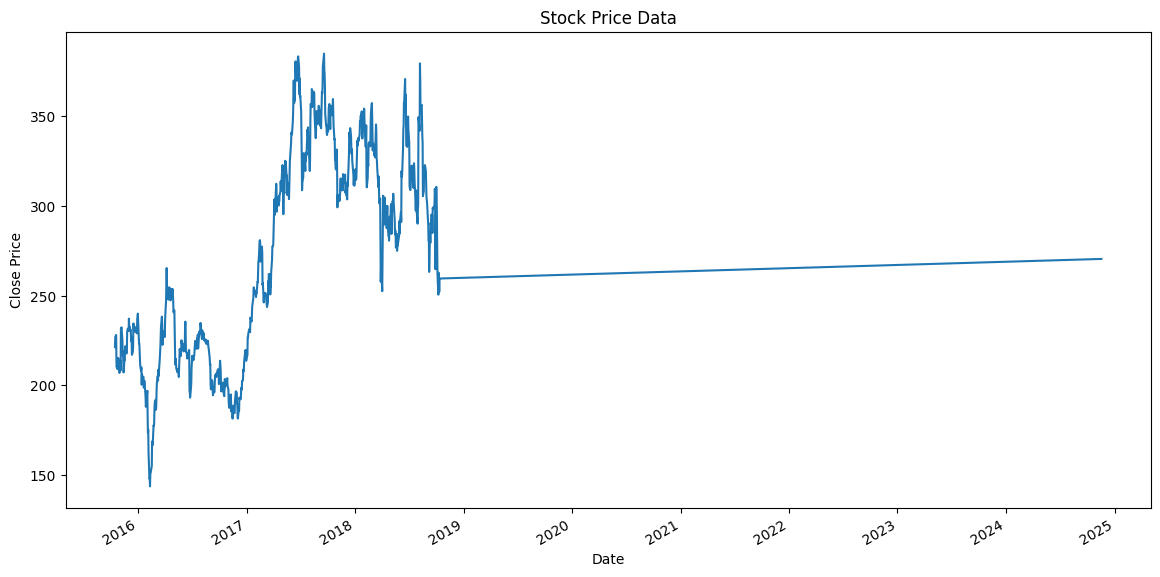

In [ ]:
# Use only the 'close' column for prediction (ensure it exists in the dataset)
data = data[['close']]

# Plot the data
data['close'].plot(figsize=(14,7))
plt.title('Stock Price Data')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into training and testing datasets (80% training, 20% testing)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create dataset with X (features) and y (target)
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])  # Use last 'time_step' closing prices as features
        y.append(data[i, 0])  # Use next closing price as target
    return np.array(X), np.array(y)

# Create training and testing datasets
X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

# Reshape data to fit LSTM model (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [ ]:
# Build the RNN model using LSTM
model = Sequential()

# LSTM layer with 50 units
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout for regularization

# Another LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer (1 unit for price prediction)
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.1509
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0185
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0112
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0098
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0078
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0086
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0082
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0107
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0097
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0083


In [ ]:
# Make predictions on test data
predictions = model.predict(X_test)

# Inverse transform predictions and actual values to get real prices
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


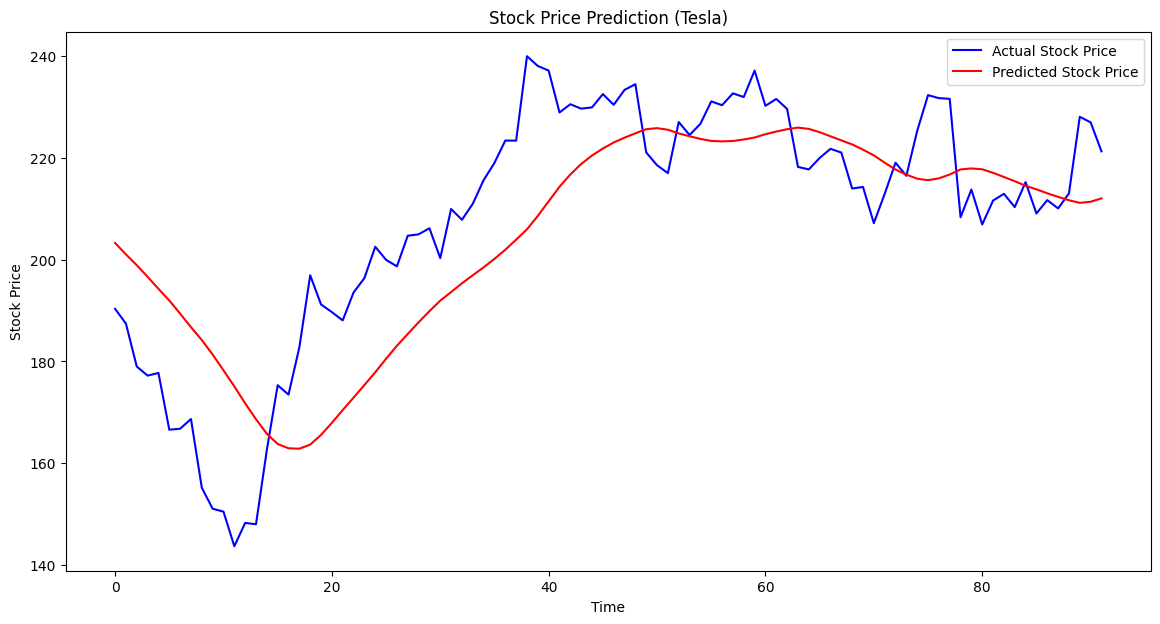

In [ ]:
# Plot the results
plt.figure(figsize=(14,7))
plt.plot(y_test_actual, color='blue', label='Actual Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction (Tesla)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
# Calculate Mean Absolute Error (MAE) to evaluate the model
mae = mean_absolute_error(y_test_actual, predictions)
print(f'Mean Absolute Error: {mae}')


Mean Absolute Error: 13.151831233812413
